In [1]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import metrics

import numpy as np
import matplotlib.pyplot as plt

from PIL import ImageFile, Image
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
import time
import requests

from imgaug import augmenters as iaa
from random import shuffle

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tf.version.GIT_VERSION, tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.4.0-rc4
v2.4.0-rc3-20-g97c3fef64ba 2.4.0-rc4


In [3]:
def displayImages(images, secondaryImages, n = 5, figsize = (30, 10)):
    
    fig = plt.figure(figsize = figsize)
    
    aspect = images[0].shape[1] / images[0].shape[0]
    
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        ax.set_aspect(aspect=5.5)

        image = images[i]
        image = image.astype('float32')
        
        plt.imshow(image, aspect=aspect)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if secondaryImages is not None:
            ax = plt.subplot(2, n, i + 1 + n)

            secondaryImage = secondaryImages[i]
            secondaryImage = secondaryImage.astype('float32')
            plt.imshow(secondaryImage, aspect=aspect)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    fig.tight_layout()
    plt.show()

In [4]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

def swish(x):
    return (K.sigmoid(x) * x)
    
get_custom_objects().update({'swish': Activation(swish)})

In [5]:
def squeeze_excite_block(tensor, branch, prefix, ratio=16):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D(name=prefix+str(branch) + "_globalAveragePooling2D")(init)
    se = Reshape(se_shape, name=prefix+str(branch) + "_reshape")(se)
    se = Dense(filters // ratio, activation='relu', name=prefix+str(branch) + "_dense1", kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', name=prefix+str(branch) + "_dense2", kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = Multiply(name=prefix+str(branch) + "_multiply")([init, se])
    return x

In [6]:
def numFilters(shape):
    if shape[1] > 512:
        return 8
    elif shape[1] > 256:
        return 32
    elif shape[1] > 128:
        return 64
    else:
        return 128

In [7]:
def filterSize(shape):
    if shape[1] > 512:
        return (5, 4)
    elif shape[1] > 256:
        return (3, 3)
    else:
        return (3, 3)

In [8]:
def dilationRate(shape):
    if shape[1] > 512:
        return (5, 4)
    elif shape[1] > 256:
        return (3, 3)
    elif shape[1] > 64:
        return (2, 2)
    else:
        return (1, 1)

In [9]:
target_size = (360, 640)
numBranches = 10
latent_space_size = 16
epsilon_std = 1.0

kernel_regularizer = None
activity_regularizer = None

In [10]:
def makeVAE():
    inputLayer = Input((target_size[0], target_size[1], 3), name="InputLayer")
    
    branchEnds = []
    
    #ENCODER
    
    for branch in range(numBranches):
        print("Creating Encoder branch:", branch)
        
        if branch == 0:
            batchNorm1 = BatchNormalization(name='encoder_'+str(branch)+'_batch_norm1')(inputLayer)
        else:
            batchNorm1 = BatchNormalization(name='encoder_'+str(branch)+'_batch_norm1')(branchEnds[-1])
        activation1 = Activation(swish, name='encoder_'+str(branch)+'_swish1')(batchNorm1)
        
        conv1_1 = Conv2D(numFilters(activation1.shape), filterSize(activation1.shape), dilation_rate=dilationRate(activation1.shape), activation=None, name='encoder_'+str(branch)+'_conv1')(activation1)

        batchNorm2 = BatchNormalization(name='encoder_'+str(branch)+'_batch_norm2')(conv1_1)
        activation2 = Activation(swish, name='encoder_'+str(branch)+'_swish2')(batchNorm2)
                            
        conv1_2 = Conv2D(numFilters(activation2.shape), filterSize(activation2.shape), dilation_rate=dilationRate(activation2.shape), activation=None, name='encoder_'+str(branch)+'_conv2')(activation2)
        
        batchNorm3 = BatchNormalization(name='encoder_'+str(branch)+'_batch_norm3')(conv1_2)
        activation3 = Activation(swish, name='encoder_'+str(branch)+'_swish3')(batchNorm3)
        
        conv1_3 = Conv2D(numFilters(activation3.shape), filterSize(activation3.shape), dilation_rate=dilationRate(activation3.shape), activation=None, name='encoder_'+str(branch)+'_conv3')(activation3)

        batchNorm4 = BatchNormalization(name='encoder_'+str(branch)+'_batch_norm4')(conv1_3)
        activation4 = Activation(swish, name='encoder_'+str(branch)+'_swish4')(batchNorm4)
                            
        conv1_4 = Conv2D(numFilters(activation4.shape), filterSize(activation4.shape), dilation_rate=dilationRate(activation4.shape), activation=None, name='encoder_'+str(branch)+'_conv4')(activation4)
        
        branchOutput = squeeze_excite_block(conv1_4, branch=branch, prefix='encoder_')
         
        branchEnds.append(branchOutput)
        
    upscaleBranchOutputs = []
    
    #DECODER
        
    for branchEndIndex in range(numBranches):
        print("Creating Decoder branch:", branchEndIndex)
        
        branch = (numBranches - branchEndIndex) - 1

        branchEndShape = branchEnds[branch].shape
        
        branchEnd = Conv2D(1, (1, 1), activation=None, name='decoder_'+str(branch)+'_conv_dimensionality_reduction')(branchEnds[branch])

        if branchEndIndex != 0:
            branchEnd = Add()([branchEnd, upscaleBranchOutputs[-1]])

        if branch % 2 != 0:
            latent_space_flatten = Flatten()(branchEnd)
            latent_space = Dense(latent_space_size, activity_regularizer=activity_regularizer)(latent_space_flatten)

            z_dense_upscale = Dense(int(branchEndShape[1] * branchEndShape[2]))(latent_space)


            if branchEndIndex == 0:
                z_reshape = Reshape((int(branchEndShape[1]), int(branchEndShape[2]), 1))(z_dense_upscale)
                z_addition = z_reshape
        else:
            z_addition = Add()([branchEnd, upscaleBranchOutputs[-1]])
            
            
        batchNorm1 = BatchNormalization(name='decoder_'+str(branch)+'_batch_norm1')(branchEnd)
        
        conv2_1 = Conv2D(numFilters(batchNorm1.shape), filterSize(batchNorm1.shape), activation=None, name="decoder_"+str(branch)+'_conv1', padding='same')(batchNorm1)
        
        batchNorm2 = BatchNormalization(name='decoder_'+str(branch)+'_batch_norm2')(conv2_1)
        activation2 = Activation(swish, name='decoder_'+str(branch)+'_swish2')(batchNorm2)
    
        if branch == 0:
            transpose_parameter_0 = int((target_size[0] - activation2.shape[1]) + 1)
            transpose_parameter_1 = int((target_size[1] - activation2.shape[2]) + 1)
        else:
            transpose_parameter_0 = int((branchEnds[branch - 1].shape[1] - activation2.shape[1]) + 1)
            transpose_parameter_1 = int((branchEnds[branch - 1].shape[2] - activation2.shape[2]) + 1)
               
        upscaleBranchOutput = Conv2DTranspose(1, (transpose_parameter_0, transpose_parameter_1), strides = (1, 1), padding = 'valid', name='decoder_'+str(branch)+'_transpose_1')(activation2)
        
        if branch == 0:
            transpose_parameter_0 = int((target_size[0] - upscaleBranchOutput.shape[1]) + 1)
            transpose_parameter_1 = int((target_size[1] - upscaleBranchOutput.shape[2]) + 1)
        else:
            transpose_parameter_0 = int((branchEnds[branch - 1].shape[1] - upscaleBranchOutput.shape[1]) + 1)
            transpose_parameter_1 = int((branchEnds[branch - 1].shape[2] - upscaleBranchOutput.shape[2]) + 1)
            
        upscaleBranchOutput = Conv2DTranspose(1, (transpose_parameter_0, transpose_parameter_1), strides = (1, 1), padding = 'valid', name='decoder_'+str(branch)+'_transpose_2')(upscaleBranchOutput)
        upscaleBranchOutputs.append(upscaleBranchOutput)
    
    output = Conv2D(3, (3, 3), activation='sigmoid', name='output', padding='same')(upscaleBranchOutputs[-1])

    vae = Model(inputs = [inputLayer], outputs = [output])

    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.000001, epsilon=None, amsgrad=False)
    vae.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
    
    return vae

In [11]:
vae = makeVAE()
vae.summary()

Creating Encoder branch: 0
Creating Encoder branch: 1
Creating Encoder branch: 2
Creating Encoder branch: 3
Creating Encoder branch: 4
Creating Encoder branch: 5
Creating Encoder branch: 6
Creating Encoder branch: 7
Creating Encoder branch: 8
Creating Encoder branch: 9
Creating Decoder branch: 0
Creating Decoder branch: 1
Creating Decoder branch: 2
Creating Decoder branch: 3
Creating Decoder branch: 4
Creating Decoder branch: 5
Creating Decoder branch: 6
Creating Decoder branch: 7
Creating Decoder branch: 8
Creating Decoder branch: 9
  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 360, 640, 3) 0                                            
_____________________________________________________________________________

In [12]:
batch_size = 2
num_epochs = 50

### Run this cell 1-10 times. Eventually it will never print "Batch complete"

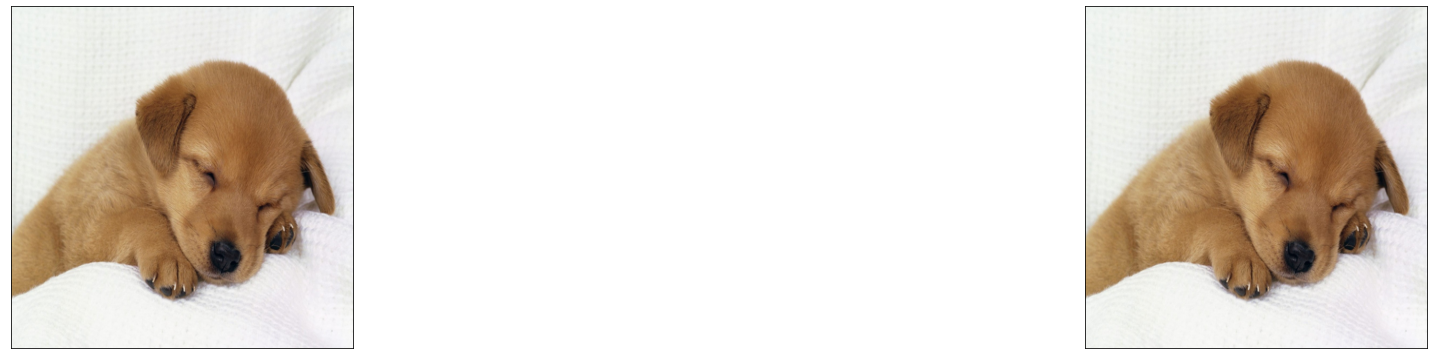

Begin training batch


In [ ]:
from io import BytesIO

url = "https://i.imgur.com/xyPtn4m.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img.resize((target_size[1], target_size[0])))
img = img / 255.

batch = []

for _ in range(batch_size):    
    batch.append(img)

displayImages(batch, None, n=min(len(batch), 5))
            
X = np.array(batch)
y = X
      
print("Begin training batch")

modelTrainStart = time.time()
metrics = vae.train_on_batch(X, y)
modelTrainEnd = time.time() - modelTrainStart

print("Batch complete | loss: %6f | acc: %6f | train: %3.2f " % (metrics[0], metrics[1], modelTrainEnd))